In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models 
from torchvision import transforms
from torchvision.utils import save_image

from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# 필요한 라이브러리 불러오기
from stylegan_model import G_mapping
from stylegan_model import G_synthesis

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
resolution = 1024
weight_file = 'weights/karras2019stylegan-ffhq-1024x1024.pt'

# StyleGAN을 구성하는 두 개의 네트워크 불러오기
g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=resolution))    
]))
g_all.load_state_dict(torch.load(weight_file, map_location=device))
g_all.eval()
g_all.to(device)
 
g_mapping, g_synthesis = g_all[0], g_all[1]

In [15]:
# 특정 경로에서 이미지를 읽어 torch.Tensor 객체로 만드는 함수
def image_reader(image_path, resize=None):
    with open(image_path, "rb") as f: # 특정 경로에서 이미지 불러오기
        image = Image.open(f)
        image = image.convert("RGB") # RGB 색상 이미지로 사용
    # 미리 정해 놓은 해상도에 맞게 크기 변환
    if resize != None:
        image = image.resize((resize, resize))
    transform = transforms.Compose([
        transforms.ToTensor() # [0, 1] 사이의 값을 가지는 Tensor 형태로 변형
    ])
    image = transform(image)
    image = image.unsqueeze(0) # 배치(batch) 목적의 차원 추가 (N, C, H, W)
    return image


# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension)을 제거
    image = image.squeeze(0)
    gray_scale = False # 흑백 이미지 여부
    if image.shape[0] == 1:
        gray_scale = True
    # PIL 객체로 변경
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 출력)
    if gray_scale: # 흑백인 경우 흑백 색상으로 출력
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()


# 화면에 출력되는 이미지 크기 조절
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

In [16]:
import warnings
warnings.filterwarnings(action='ignore') # 경고(warning) 메시지 보이지 않도록 하기


# VGG를 활용한 특징 추출기(Feature Extractor)
class FeatureExtractor(torch.nn.Module):
    def __init__(self, n_layers):
        super(FeatureExtractor, self).__init__()
        extractor = models.vgg16(pretrained=True).features

        # 각 레이어까지의 출력 값을 계산 (n_layers=[1, 3, 13, 20])
        index = 0
        self.layers = nn.ModuleList([])
        for i in range(len(n_layers)):
            # 해당 레이어까지의 출력 값을 내보낼 수 있도록 하기
            self.layers.append(torch.nn.Sequential())
            for j in range(index, n_layers[i] + 1):
                self.layers[i].add_module(str(j), extractor[j])
            index = n_layers[i] + 1

        # 모델을 학습할 필요는 없으므로 기울기 추적 중지
        for param in self.parameters():
            param.requires_grad = False

    # 각 레이어까지의 출력 값들을 리스트에 담아 반환
    def forward(self, x):
        result = []
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            result.append(x)

        return result

In [17]:
# 생성된 이미지(generated_image)와 대상 이미지(target_image)에 대한 손실(loss)을 계산
def loss_function(generated_image, target_image, feature_extractor):
    MSE = nn.MSELoss(reduction='mean')
    mse_loss = MSE(generated_image, target_image) # 손실(loss) 값 계산

    # VGG 네트워크의 입력은 256이므로, 크기를 256으로 바꾸는 업샘플링(upsampling)을 이용합니다.
    upsample2d = torch.nn.Upsample(scale_factor=256 / resolution, mode='bilinear')
    real_features = feature_extractor(upsample2d(target_image))
    generated_features = feature_extractor(upsample2d(generated_image))

    perceptual_loss = 0
    # 활성화 맵(activation map)의 개수만큼 반복하며
    for i in range(len(real_features)):
        perceptual_loss += MSE(real_features[i], generated_features[i]) # 손실(loss) 값 계산

    return mse_loss, perceptual_loss

[iter 1/1500] loss = 7.846250534057617, saved_path = barack_obama_1.png
[iter 100/1500] loss = 1.7419497966766357, saved_path = barack_obama_100.png
[iter 200/1500] loss = 1.4153225421905518, saved_path = barack_obama_200.png
[iter 300/1500] loss = 1.235959768295288, saved_path = barack_obama_300.png
[iter 400/1500] loss = 1.175686240196228, saved_path = barack_obama_400.png
[iter 500/1500] loss = 1.098365306854248, saved_path = barack_obama_500.png
[iter 600/1500] loss = 1.023902416229248, saved_path = barack_obama_600.png
[iter 700/1500] loss = 1.0200711488723755, saved_path = barack_obama_700.png
[iter 800/1500] loss = 0.9458926916122437, saved_path = barack_obama_800.png
[iter 900/1500] loss = 0.9196912050247192, saved_path = barack_obama_900.png
[iter 1000/1500] loss = 0.9212073683738708, saved_path = barack_obama_1000.png
[iter 1100/1500] loss = 0.8421720862388611, saved_path = barack_obama_1100.png
[iter 1200/1500] loss = 0.8666549324989319, saved_path = barack_obama_1200.png
[i

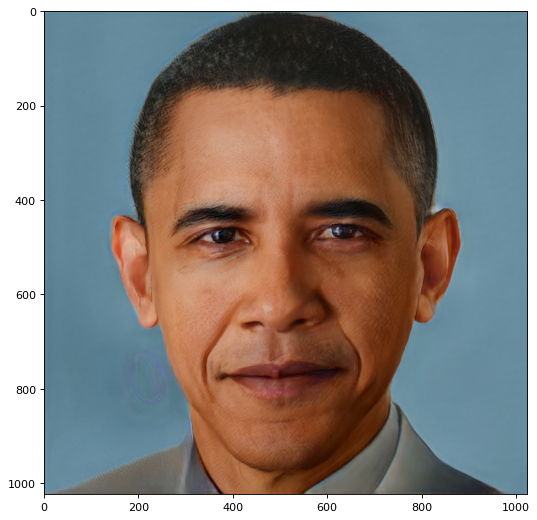

In [18]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # 업데이트할 latent vector 변수
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss를 위한 레이어 명시
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

# 이미지 불러오기
name = 'barack_obama'
src = f'source_image/{name}.jpg'
image = image_reader(src, resize=resolution)
image = image.to(device)

# 최적화(optimization) 시작
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # latent vector를 이용해 이미지 생성
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    # 손실(loss) 값 계산
    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # 기울기(gradient) 계산

    optimizer_latent.step() # latent vector 업데이트

    # 주기적으로 손실(loss) 값 및 이미지 출력
    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'./save_image/{name}_{i + 1}.png')
        np.save(f'./latents/{name}_latent.npy', latent.detach().cpu().numpy())

print("[ 임베딩 결과 ]")
imshow(generated_image)

[iter 1/1500] loss = 8.152732849121094, saved_path = hugh_jackman_1.png
[iter 100/1500] loss = 3.0374574661254883, saved_path = hugh_jackman_100.png
[iter 200/1500] loss = 2.505218267440796, saved_path = hugh_jackman_200.png
[iter 300/1500] loss = 2.1807639598846436, saved_path = hugh_jackman_300.png
[iter 400/1500] loss = 1.9727530479431152, saved_path = hugh_jackman_400.png
[iter 500/1500] loss = 1.854205846786499, saved_path = hugh_jackman_500.png
[iter 600/1500] loss = 1.7776236534118652, saved_path = hugh_jackman_600.png
[iter 700/1500] loss = 1.7569063901901245, saved_path = hugh_jackman_700.png
[iter 800/1500] loss = 1.650692343711853, saved_path = hugh_jackman_800.png
[iter 900/1500] loss = 1.6234662532806396, saved_path = hugh_jackman_900.png
[iter 1000/1500] loss = 1.574626088142395, saved_path = hugh_jackman_1000.png
[iter 1100/1500] loss = 1.5387227535247803, saved_path = hugh_jackman_1100.png
[iter 1200/1500] loss = 1.5127707719802856, saved_path = hugh_jackman_1200.png
[i

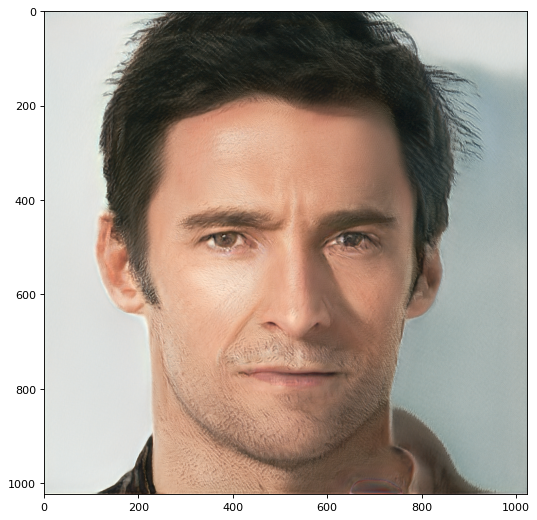

In [19]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # 업데이트할 latent vector 변수
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss를 위한 레이어 명시
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

# 이미지 불러오기
name = 'hugh_jackman'
src = f'source_image/{name}.jpg'
image = image_reader(src, resize=resolution)
image = image.to(device)

# 최적화(optimization) 시작
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # latent vector를 이용해 이미지 생성
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    # 손실(loss) 값 계산
    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # 기울기(gradient) 계산

    optimizer_latent.step() # latent vector 업데이트

    # 주기적으로 손실(loss) 값 및 이미지 출력
    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'./save_image/{name}_{i + 1}.png')
        np.save(f'./latents/{name}_latent.npy', latent.detach().cpu().numpy())

print("[ 임베딩 결과 ]")
imshow(generated_image)

[ 이미지 보간법(Interpolation) ]


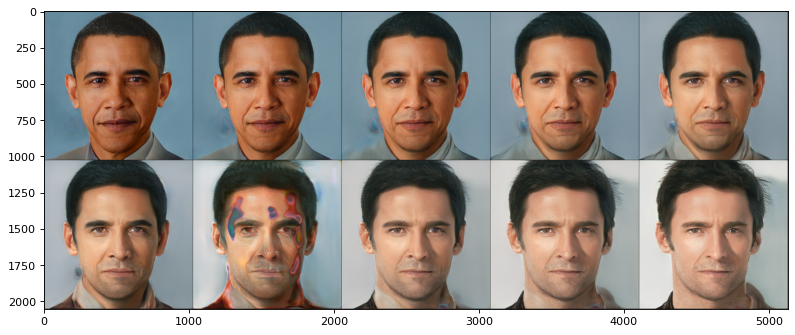

In [20]:
print('[ 이미지 보간법(Interpolation) ]')

# .npy 파일로부터 두 w 벡터 불러오기
w_1 = np.load('./latents/barack_obama_latent.npy')
w_2 = np.load('./latents/hugh_jackman_latent.npy')

name = 'interpolation'
interpolated_images = []

# 두 벡터간 모핑(morphing) 수행하기
with torch.no_grad(): # GPU 용량 낭비를 줄이기 위해 기울기를 추적하지 않도록 하기
    for alpha in np.linspace(0, 1, 10):
        w = (1 - alpha) * w_1 + alpha * w_2
        w = torch.tensor(w).to(device)
        image = g_synthesis(w)
        image = ((image + 1.0) / 2.0).clamp(0, 1)
        interpolated_images.append(image)

# 결과 이미지를 격자(grid) 형태로 저장
grid_image = torchvision.utils.make_grid(torch.cat(interpolated_images, dim=0), nrow=5)
save_image(grid_image, f"{name}.png")
imshow(grid_image)